In [1]:
from datetime import datetime, timedelta

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import baostock as bs
import seaborn as sns

sns.set_theme()

In [2]:
torch.__version__

'2.0.0'

In [3]:
torch.cuda.is_available()

True

In [4]:
def get_tradingdays(backdays):
    end = datetime.now()
    start = (end - timedelta(days=100)).strftime("%Y-%m-%d")
    rs = bs.query_trade_dates(start, end)
    data_list = []
    while (rs.error_code == "0") and rs.next():
        data_list.append(rs.get_row_data())
        
    result = pd.DataFrame(data_list, columns=rs.fields)
    result["is_trading_day"] = result["is_trading_day"].astype(int)
    
    return result[result["is_trading_day"] == True][-backdays:]["calendar_date"].tolist()

In [5]:
bs.login()
days = get_tradingdays(20)
bs.logout()
days

login success!
logout success!


['2023-03-17',
 '2023-03-20',
 '2023-03-21',
 '2023-03-22',
 '2023-03-23',
 '2023-03-24',
 '2023-03-27',
 '2023-03-28',
 '2023-03-29',
 '2023-03-30',
 '2023-03-31',
 '2023-04-03',
 '2023-04-04',
 '2023-04-06',
 '2023-04-07',
 '2023-04-10',
 '2023-04-11',
 '2023-04-12',
 '2023-04-13',
 '2023-04-14']

In [6]:
def get_zz500():
    rs = bs.query_zz500_stocks()
    data_list = []
    while (rs.error_code == "0") and rs.next():
        idx = rs.fields.index("code")
        data_list.append(rs.get_row_data()[idx])
    
    return data_list

In [7]:
def get_quote(code, start, end):
    rs = bs.query_history_k_data_plus(code, "open,high,low,close,volume", start_date=start, end_date=end, frequency="d", adjustflag="2")
    data_list = []
    while (rs.error_code == "0") and rs.next():
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields).astype(np.float32)
    
    return result

In [8]:
bs.login()
zz500 = get_zz500()
bs.logout()

login success!
logout success!


In [9]:
bs.login()
df = get_quote("sh.600036", "2000-01-01", "2023-04-09")
df.columns = ["Open", "High", "Low", "Close", "Volume"]
bs.logout()

login success!
logout success!


<Axes: ylabel='Close'>

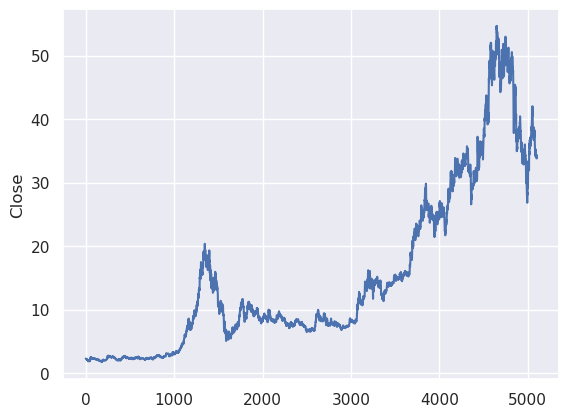

In [10]:
sns.lineplot(df["Close"])

In [11]:
len(df)

5101

In [12]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
df['Volume'][df["Volume"] == np.inf] = 0

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (4042, 5)
Validation data shape: (505, 5)
Test data shape: (505, 5)


,Open,High,Low,Close,Volume
1,0.439556,0.340741,0.357179,0.375743,0.011945
2,0.375743,0.387798,0.424653,0.369591,0.024418
3,0.363540,0.381782,0.390734,0.409032,0.067910
4,0.415169,0.381736,0.354015,0.339185,0.063469
5,0.327051,0.330265,0.328730,0.322808,0.097926


<Axes: ylabel='Volume'>

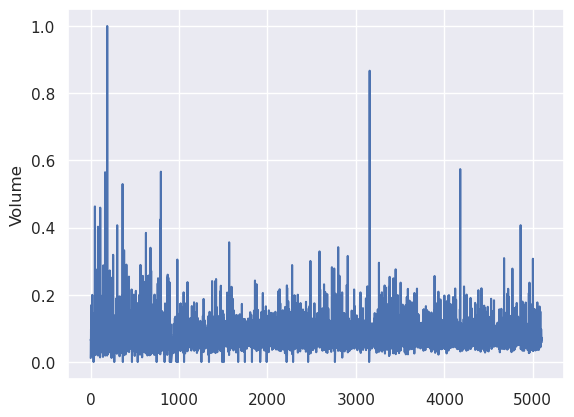

In [13]:
sns.lineplot(df["Volume"])

<Axes: ylabel='Close'>

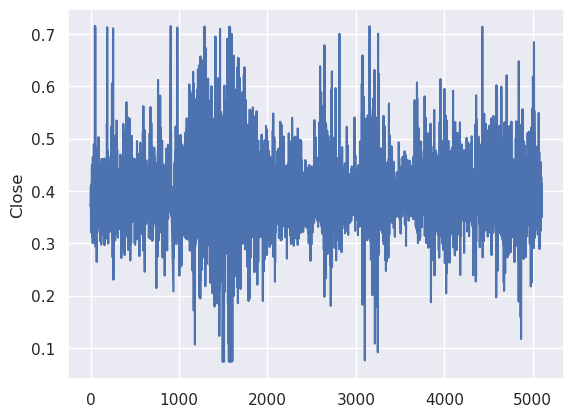

In [14]:
sns.lineplot(df["Close"])

In [15]:
seq_len = 32

In [16]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (4010, 32, 5) (4010,)
Validation set shape (473, 32, 5) (473,)
Testing set shape (473, 32, 5) (473,)


In [17]:
class TimeVector(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = int(seq_len)
        
        self.linear_w = nn.Parameter(torch.randn(self.seq_len))
        self.linear_b = nn.Parameter(torch.randn(self.seq_len))
        self.periodic_w = nn.Parameter(torch.randn(self.seq_len))
        self.periodic_b = nn.Parameter(torch.randn(self.seq_len))
        
    def forward(self, x):
        x = x[:,:4].mean(axis=-1)
        time_linear = self.linear_w * x + self.linear_b
        time_linear = torch.unsqueeze(time_linear, dim=-1)
        time_periodic = torch.sin(self.periodic_w * x + self.periodic_b)
        time_periodic = torch.unsqueeze(time_periodic, dim=-1)
        return torch.concat([time_linear, time_periodic], axis=-1)

In [18]:
class SingleAttention(nn.Module):
    def __init__(self, d_k, d_v):
        super().__init__()
        self.d_k = d_k
        self.d_v = d_v
        
        self.query = nn.Linear(7, self.d_k)
        self.key = nn.Linear(7, self.d_k)
        self.value = nn.Linear(7, self.d_v)
        
    def forward(self, x):
        q = self.query(x[0])
        k = self.key(x[1])
        
        out = torch.mm(q, k.mT)
        out = out / np.sqrt(self.d_k)
        out = torch.softmax(out, axis=-1)
        
        v = self.value(x[2])
        out = torch.mm(out, v)
        
        return out

In [19]:
class MultiAttention(nn.Module):
    def __init__(self, d_k, d_v, n_heads):
        super().__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = []
        
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))
            
        self.linear = nn.Linear(self.d_k * self.n_heads, 7)
        
    def forward(self, x):
        attns = [head(x) for head in self.attn_heads]
        concat_attns = torch.concat(attns, axis=-1)
        return self.linear(concat_attns)

In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.ff_dim = ff_dim
        self.n_heads = n_heads
        self.attn_heads = []
        self.dropout_rate = dropout
        
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = nn.Dropout(self.dropout_rate)
        self.attn_normalize = nn.LayerNorm((seq_len, 7), eps=1e-6)
        
        self.ff_conv1d_1 = nn.Conv1d(seq_len, ff_dim, kernel_size=1)
        self.ff_conv1d_2 = nn.Conv1d(ff_dim, seq_len, kernel_size=1)
        self.ff_dropout = nn.Dropout(self.dropout_rate)
        self.ff_normalize = nn.LayerNorm((seq_len, 7), eps=1e-6)
        
    def forward(self, x):
        attn_layer = self.attn_multi(x)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(x[0] + attn_layer)
        
        ff_layer = self.ff_conv1d_1(attn_layer)
        ff_layer = F.relu(ff_layer)
        ff_layer = self.ff_conv1d_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(x[0] + ff_layer)
        
        return ff_layer

In [21]:
class TimeEmbeddingTransformer(nn.Module):
    def __init__(self, seq_len, d_k, d_v, n_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.ff_dim = ff_dim
        self.n_heads = n_heads
        self.attn_heads = []
        self.dropout_rate = dropout
        
        self.time_embedding = TimeVector(seq_len)
        self.attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
        self.attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
        self.attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.linear1 = nn.Linear(seq_len, seq_len // 2)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.linear2 = nn.Linear(seq_len // 2, 1)
        
    def forward(self, x):
        time_embedding = self.time_embedding(x)
        x = torch.concat([x, time_embedding], axis=-1)
        x = self.attn_layer1((x, x, x))
        x = self.attn_layer2((x, x, x))
        x = self.attn_layer3((x, x, x))
        x = x.mean(axis=-1)
        x = self.dropout1(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        
        return x

In [22]:
model = TimeEmbeddingTransformer(seq_len, 64, 64, 12, 64)

In [23]:
model

TimeEmbeddingTransformer(
  (time_embedding): TimeVector()
  (attn_layer1): TransformerEncoder(
    (attn_multi): MultiAttention(
      (linear): Linear(in_features=768, out_features=7, bias=True)
    )
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (attn_normalize): LayerNorm((32, 7), eps=1e-06, elementwise_affine=True)
    (ff_conv1d_1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (ff_conv1d_2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (ff_dropout): Dropout(p=0.1, inplace=False)
    (ff_normalize): LayerNorm((32, 7), eps=1e-06, elementwise_affine=True)
  )
  (attn_layer2): TransformerEncoder(
    (attn_multi): MultiAttention(
      (linear): Linear(in_features=768, out_features=7, bias=True)
    )
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (attn_normalize): LayerNorm((32, 7), eps=1e-06, elementwise_affine=True)
    (ff_conv1d_1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (ff_conv1d_2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (ff_drop

In [24]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [25]:
for epoch in range(2):
    running_loss = 0
    for i, data in enumerate(X_train):
        optimizer.zero_grad()
        # data = torch.unsqueeze(torch.tensor(data), dim=0)
        y_pred = model(torch.tensor(data))
        loss = loss_function(y_pred, torch.tensor(y_train[i]))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 500 == 0:
            print(f"{epoch=}, {i=}, {running_loss=:.5f}")
            running_loss = 0
        

/home/liruide/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch=0, i=0, running_loss=0.11965
epoch=0, i=500, running_loss=3.62821
epoch=0, i=1000, running_loss=2.96005
epoch=0, i=1500, running_loss=7.02415
epoch=0, i=2000, running_loss=4.60735
epoch=0, i=2500, running_loss=1.20859
epoch=0, i=3000, running_loss=1.95966
epoch=0, i=3500, running_loss=2.50266
epoch=0, i=4000, running_loss=1.68218
epoch=1, i=0, running_loss=0.00064
epoch=1, i=500, running_loss=1.92146
epoch=1, i=1000, running_loss=1.77659
epoch=1, i=1500, running_loss=5.66165
epoch=1, i=2000, running_loss=4.04988
epoch=1, i=2500, running_loss=0.99803
epoch=1, i=3000, running_loss=1.80833
epoch=1, i=3500, running_loss=2.38265
epoch=1, i=4000, running_loss=1.62330


In [26]:
model.eval()

TimeEmbeddingTransformer(
  (time_embedding): TimeVector()
  (attn_layer1): TransformerEncoder(
    (attn_multi): MultiAttention(
      (linear): Linear(in_features=768, out_features=7, bias=True)
    )
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (attn_normalize): LayerNorm((32, 7), eps=1e-06, elementwise_affine=True)
    (ff_conv1d_1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (ff_conv1d_2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (ff_dropout): Dropout(p=0.1, inplace=False)
    (ff_normalize): LayerNorm((32, 7), eps=1e-06, elementwise_affine=True)
  )
  (attn_layer2): TransformerEncoder(
    (attn_multi): MultiAttention(
      (linear): Linear(in_features=768, out_features=7, bias=True)
    )
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (attn_normalize): LayerNorm((32, 7), eps=1e-06, elementwise_affine=True)
    (ff_conv1d_1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (ff_conv1d_2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (ff_drop

In [27]:
y_val_pred = []
for data in X_val:
    y_val_pred.append(model(torch.tensor(data)).detach().numpy()[0])

<Axes: >

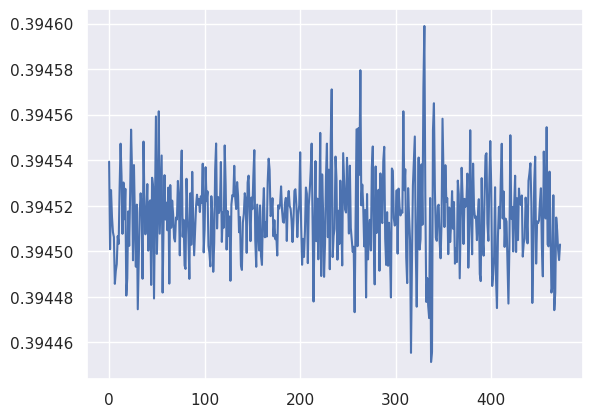

In [28]:
sns.lineplot(y_val_pred)

<Axes: >

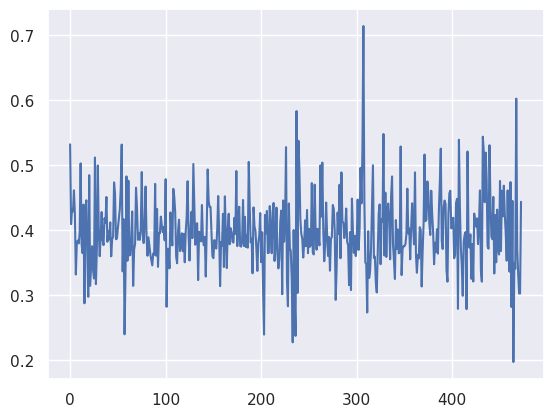

In [29]:
sns.lineplot(y_val)